# AML Exam (Skin disease image classification)

# 1. Importing Libraries / Defining Global Functions

In [1]:
import random # Generating Random Numbers
import os # Loading images
import shutil # Copying and moving images
import numpy as np # Handling big data
import cv2 # Image loading and augmenting
from matplotlib import pyplot as plt # Visualizing Data
import pickle # Saving/loading models

# Remove unneccesary warning messages
import warnings
warnings.filterwarnings("ignore")

# Gathering model results
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# .DS_Store and .ipynb_checkpoints was generated automatically
# throughout this project, and this would mess up our loops when
# loading images, this function makes sure the loaded list deletes
# theese files to prevent problems.
def remove_unwanted_folders(folder):
    if ".DS_Store" in folder:
        folder.remove(".DS_Store")
    if ".ipynb_checkpoints" in folder:
        folder.remove(".ipynb_checkpoints")

# 2. Augmenting Data

## • Augmenting Data to get more samples.

In [18]:
class Generate_folders():
    """Class to generate all class folders inside a new directory:
       Parameters:
       - original_data_path: path to original dataset containing all disease folders.
       - original_data_path type: str
       
       - save_data_path: path to folder where all folders will be (has to be empty)
       - save_data_path type: str"""

    def __init__(self, original_data_path, save_data_path):
        self.o_data_path = original_data_path
        self.s_data_path = save_data_path
        
    def generate_folders(self):
        """This function generates train, validation and test folders containing all target classes."""

        # Function for creating folders.
        def create_folders():
            # Define folders to generate
            folders = ["train","val","test"]

            for folder in folders:
                # Create new folders with the name of train, val, or test
                os.mkdir(os.path.join(self.s_data_path,folder))

                # For each folder, create new folder with each class labels (diseases)
                for disease in disease_folder:
                    os.mkdir(os.path.join(self.s_data_path,folder,disease))
            print("Folders Created!")
        
        # Gathering parameters (paths) into variables.
        disease_path = self.o_data_path
        disease_folder = os.listdir(disease_path)
        remove_unwanted_folders(disease_folder)
        
        save_path = self.s_data_path
        save_folder = os.listdir(self.s_data_path)
        remove_unwanted_folders(save_folder)
        
        # Check if the Target folder is not empty
        if save_folder != []:
            # If the target folder is not empty, prompt the user to overwrite or not
            print("Save folder not empty!")
            u_input = input("Do you wish to overwrite? (y/n)")
            
            # If they decide to overwrite, remove train, val, test folders
            if u_input == "y":
                for folder in save_folder:
                    shutil.rmtree(os.path.join(save_path,folder))
                    
                # Recreate folders
                create_folders()
            else:
                # If they do not decide to overwrite:
                print("Please delete folders and try again.") 
        else:
            # If the Target folder is empty, generate folders.
            create_folders()

In [20]:
folder_generator = Generate_folders("./Data/original_data","./Data/test/")

In [ ]:
folder_generator.generate_folders()

In [ ]:
del(augmentor)

## • Defining Augmentation Functions

In [26]:
def save_Augmented_Image(save_path,img):
    cv2.imwrite(save_path,img)
    
def generate_r_value(min_value, max_value, d_type="int"):
    if d_type == "int":
        rand_n = random.randint(min_value, max_value)
    elif d_type == "float":
        rand_n = random.uniform(min_value, max_value)
    return rand_n

## • Loading directories

In [4]:
# Get list of all disease folders in data
original_data_path = "./Data/original_data/"
original_data_folder = os.listdir(original_data_path)
remove_unwanted_folders(original_data_folder)

augmented_data_path = "./Data/test/"
#augmented_data_folder = os.listdir(augmented_data_path)

## • Augmenting Images

In [ ]:
# Specify Parameters
copies = 2

brightness_min = -60
brightness_max = 90

contrast_min = 0.5
contrast_max = 1.7


id_counter = 0
for disease in original_data_folder: # Looping over all disease folders
    # Get all images inside of current disease folder
    images = os.listdir(os.path.join(original_data_path,disease))

    # Loading each image in folder
    for current_image in images:
        # Get full path of current image
        current_image_full_path = os.path.join(original_data_path, disease, current_image)
        
        
        # ----- Augment Orginal ----
        id_counter +=1
        current_image_cv2 = cv2.imread(current_image_full_path)                              
        save_Augmented_Image(os.path.join(augmented_data_path, disease, f"o_{id_counter}_"+current_image),current_image_cv2)
        
        # Adjust Brightness
        for x in range(copies):
            id_counter +=1
            brightness_image = cv2.convertScaleAbs(current_image_cv2, alpha=1, beta=generate_r_value(brightness_min,brightness_max))
            save_Augmented_Image(os.path.join(augmented_data_path,disease,f"o_b_{id_counter}_"+current_image),brightness_image)
        
        # Adjust Contrast
        for x in range(copies):
            id_counter +=1
            contrast_image = cv2.convertScaleAbs(current_image_cv2, alpha=generate_r_value(contrast_min, contrast_max,"float"), beta=0)
            save_Augmented_Image(os.path.join(augmented_data_path,disease,f"o_c_{id_counter}_"+current_image),contrast_image)
        
        
        
        # ---- FLip Horizontal ----
        # Flip Horizontal
        id_counter +=1
        horizontal_flip_image = cv2.flip(current_image_cv2,1)
        save_Augmented_Image(os.path.join(augmented_data_path,disease,f"hF_{id_counter}_"+current_image),horizontal_flip_image)
        
        # Adjust Brightness
        for x in range(copies):
            id_counter +=1
            brightness_image = cv2.convertScaleAbs(horizontal_flip_image, alpha=1, beta=generate_r_value(brightness_min,brightness_max))
            save_Augmented_Image(os.path.join(augmented_data_path,disease,f"hf_b_{id_counter}_"+current_image),brightness_image)
        
        # Adjust Contrast
        for x in range(copies):
            id_counter +=1
            contrast_image = cv2.convertScaleAbs(horizontal_flip_image, alpha=generate_r_value(contrast_min, contrast_max, "float"), beta=0)
            save_Augmented_Image(os.path.join(augmented_data_path,disease,f"hf_c_{id_counter}_"+current_image),contrast_image)
            
           
        
        # ---- FLip Vertical ---
        # Flip Vertical
        id_counter +=1
        vertical_flip_image = cv2.flip(current_image_cv2,0)
        save_Augmented_Image(os.path.join(augmented_data_path,disease,f"vF_{id_counter}_"+current_image),vertical_flip_image)
        
        # Adjust Brightness
        for x in range(copies):
            id_counter +=1
            brightness_image = cv2.convertScaleAbs(vertical_flip_image, alpha=1, beta=generate_r_value(brightness_min, brightness_max))
            save_Augmented_Image(os.path.join(augmented_data_path,disease,f"vf_b_{id_counter}_"+current_image),brightness_image)
        
        # Adjust Contrast
        for x in range(copies):
            id_counter +=1
            contrast_image = cv2.convertScaleAbs(vertical_flip_image, alpha=generate_r_value(contrast_min , contrast_max, "float"), beta=0)
            save_Augmented_Image(os.path.join(augmented_data_path,disease,f"vf_c_{id_counter}_"+current_image),contrast_image)    

## • Saving augmented data into train, validation and test

### • Loading directory

In [52]:
# Get list of all disease folders in data
original_data_path = "./Data/test/"
original_data_folder = os.listdir(original_data_path)

remove_unwanted_folders(original_data_folder)
print(original_data_folder)

[]


### • Calculating train, test, validation sizes and moving images

In [77]:
for disease in original_data_folder:
    # Get all images inside each corresponding disease folder
    disease_images = os.listdir(os.path.join(original_data_path,disease))
    remove_unwanted_folders(disease_images)
    images = np.array(disease_images)
    images.shuffle()
    
# Calculating Train, Validation and Test image count
    train_partition = int(len(images)*.7)
    validation_partition = int(len(images)*.2)
    test_partition = int(len(images)*.1)
    
# Empty lists to store all numbers in range into a list.
    train_partition_indexes = []
    validation_partition_indexes = []
    test_partition_indexes = []
    

# Array of Train images from partition.
    for x in range(0,train_partition):
        train_partition_indexes.append(x)
    train_image_array = np.take(images,train_partition_indexes)
    
# Array of Validation images from partition.
    for x in range(train_partition, train_partition + validation_partition):
        validation_partition_indexes.append(x)
    validation_image_array = np.take(images, validation_partition_indexes)
    
# Array of Test images from partition.
    for x in range(train_partition + validation_partition , train_partition + validation_partition + test_partition):
        test_partition_indexes.append(x)
    test_image_array = np.take(images, test_partition_indexes)
        

# Defining path to new folders
    train_folder_path = "./Data/augmented_data/train/"
    validation_folder_path = "./Data/augmented_data/val/"
    test_folder_path = "./Data/augmented_data/test/"
    
    
# Moving images to their respective train, validation and test folders
    # • Train Images
    for current_image in train_image_array:
        current_image_full_path = os.path.join(original_data_path, disease, current_image)
        shutil.copyfile(current_image_full_path, os.path.join(train_folder_path, disease, current_image))

    # • Validation Images
    for current_image in validation_image_array:
        current_image_full_path = os.path.join(original_data_path, disease, current_image)
        shutil.copyfile(current_image_full_path, os.path.join(validation_folder_path, disease, current_image))
    
    # • Test Images
    for current_image in test_image_array:
        current_image_full_path = os.path.join(original_data_path, disease, current_image)
        shutil.copyfile(current_image_full_path, os.path.join(test_folder_path, disease, current_image)) 

# 3. Data Processor Class

In [2]:
class DataProcessor:
    __doc__ = "Class that assists with different data processing actions."
    
    def __init__(self, original_data_path, target_folder):
        self.original_path = original_data_path
        self.classes = os.listdir(self.original_path)
        remove_unwanted_folders(self.classes)
        
        self.target_path = target_folder
        self.target_folder = os.listdir(self.target_path)
        remove_unwanted_folders(self.target_folder)
        
        print("Data Processor successfully created!")
    
    def generate_x_y(self, class_folder, shuffle="True"):
        # Creates temporary lists to store images
        temp_x = []
        temp_y = []

        # Gathering Training Data
        for class_label in self.classes:
            images = os.listdir(os.path.join(class_folder, class_label))
            for current_image in images:
                # Load every image in current class folder as cv2 image
                current_image_full_path = os.path.join(class_folder, class_label, current_image)
                current_image = cv2.imread(current_image_full_path)
                current_image = cv2.resize(current_image,(224,224))

                # Adds current image to list, flattened.
                temp_x.append(current_image.flatten())
                temp_y.append(class_label)
                
        # Convert from list to array, len(temp_x) is the amount of images (array rows) and -1 is the total lenght of values (coloumns)
        # Theese values are divided by 255 to convert from standard RGB 0-255 into a more machine learning friendly 0-1 values.
        temp_x = np.array(temp_x).reshape(len(temp_x), -1)/255
        temp_y = np.array(temp_y)
        
        def unison_shuffle(self, array_x, array_y):
            assert len(array_x) == len(array_y)
            shuffle = np.random.permutation(len(array_y))
            return array_x[shuffle], Y_array[shuffle]
        
        if shuffle == True:
            temp_x , temp_y = self.unison_shuffle(temp_x, temp_y)
        print(f"{len(temp_x)} images within {len(self.classes)} classes successfully loaded!")
        return temp_x, temp_y
    generate_x_y.__doc__ = '''This function will generate array of X and array of Y data from chosen folder.
                              Folder has to contain all classes.
                              
                              Parameters:
                              
                              - class_folder: path to folder containing all classes.
                              
                              - Shuffle: Wheter to shuffle data before returning arrays.
                                         Defaults is True.
                                         
                              Example:
                              train_x, train_y = generate_x_y("./train/")'''
    
    def generate_folders(self):
        # Function for creating folders.
        def create_folders(target_path):
            # Define folders to generate
            folders = ["train","val","test"]

            for folder in folders:
                # Create new folders with the name of train, val, or test
                os.mkdir(os.path.join(self.target_path, folder))

                # For each folder, create new folder with each class labels (diseases)
                for class_label in self.classes:
                    os.mkdir(os.path.join(self.target_path, folder, class_label))
            print("Train, Val and test folders created!")
        
        target_folder = os.listdir(self.target_path)
        
        # Check if the Target folder is empty or contains "temp"
        if (target_folder == ['temp']) or (target_folder == []):
            create_folders(self.target_path)
        else:
            # If the target folder is not empty
            print("Save folder not empty!")
            u_input = input("Do you wish to overwrite? (y/n)")

            # If they decide to overwrite, remove train, val, test folders
            if u_input == "y":
                for folder in target_folder:
                    # Keep temp folder if it exists.
                    if folder == "temp":
                        pass
                    else:
                        shutil.rmtree(os.path.join(self.target_path, folder))

                # Recreate folders
                create_folders(self.target_path)
            else:
                # If they do not decide to overwrite:
                print("Please delete folders and try again.")
    generate_folders.__doc__ = '''The generate_folders() function will generate train, validation and test folders.
                                  Theese folders will be populated with every class found in the original dataset.
                                  If the folder is not empty it will prompt to overwrite current train, val and test folders.
                                  The "temp" folder generated with augment_images will not be removed when overwriting.'''
            
    
    def move_images(self):
        total_train_images = 0
        total_val_images = 0
        total_test_images = 0
        target_folder = os.listdir(self.target_path)
        if "train" in target_folder and "val" in target_folder and "train" in target_folder:
            for class_label in self.classes:
                # Get all images inside each corresponding disease folder
                images = os.listdir(os.path.join(self.target_path,"temp",class_label))
                remove_unwanted_folders(images)
                images = np.array(images)
                np.random.shuffle(images)

            # Calculating Train, Validation and Test image count
                train_partition = int(len(images)*.7)
                total_train_images += train_partition
                
                validation_partition = int(len(images)*.2)
                total_val_images += validation_partition
                
                test_partition = int(len(images)*.1)
                total_test_images += test_partition

            # Empty lists to store all numbers in range into a list.
                train_partition_indexes = []
                validation_partition_indexes = []
                test_partition_indexes = []

            # Array of Train images from partition.
                for x in range(0,train_partition):
                    train_partition_indexes.append(x)
                train_image_array = np.take(images,train_partition_indexes)

            # Array of Validation images from partition.
                for x in range(train_partition, train_partition + validation_partition):
                    validation_partition_indexes.append(x)
                validation_image_array = np.take(images, validation_partition_indexes)

            # Array of Test images from partition.
                for x in range(train_partition + validation_partition , train_partition + validation_partition + test_partition):
                    test_partition_indexes.append(x)
                test_image_array = np.take(images, test_partition_indexes)


            # Moving images to their respective train, validation and test folders
                # • Train Images
                for current_image in train_image_array:
                    current_image_full_path = os.path.join(self.target_path,"temp",class_label, current_image)
                    shutil.copyfile(current_image_full_path, os.path.join(self.target_path,"train",class_label, current_image))

                # • Validation Images
                for current_image in validation_image_array:
                    current_image_full_path = os.path.join(self.target_path,"temp",class_label, current_image)
                    shutil.copyfile(current_image_full_path, os.path.join(self.target_path,"val",class_label, current_image))

                # • Test Images
                for current_image in test_image_array:
                    current_image_full_path = os.path.join(self.target_path, "temp", class_label, current_image)
                    shutil.copyfile(current_image_full_path, os.path.join(self.target_path,"test",class_label,current_image))
            print(f"{total_train_images} images moved into train.")
            print(f"{total_val_images} images moved into val.")
            print(f"{total_test_images} images moved into test.")
            shutil.rmtree(os.path.join(self.target_path, "temp"))
        else:
            print("Folder is missing train, val, and test folders, please run generate_folders() first.")
    move_images.__doc__ = '''The move_images function will transfer all augmented data into train, val and test
                             from temp which is generated using the augment_images() function.'''
            
        
    
    def augment_images(self, copies=2, brightness=[-60,90], contrast=[0.5,1.7], zoom=[20,40]):
        # Defining Functions used for augmentation
        def save_Augmented_Image(save_path,img):
            cv2.imwrite(save_path,img)

        def generate_r_value(min_value, max_value):
            if (type(min_value) == int) or (type(max_value) == int):
                rand_n = random.randint(min_value, max_value)
            if (type(min_value) == float) or (type(max_value) == float):
                rand_n = random.uniform(min_value, max_value)
            return rand_n
    
        # Specify Parameters
        brightness_min = brightness[0]
        brightness_max = brightness[1]
        contrast_min = contrast[0]
        contrast_max = contrast[1]
        zoom_min = zoom[0]
        zoom_max = zoom[1]
        
        # Create temporary folder
        if "temp" in (os.listdir(self.target_path)):
            print("temp was already in target folder, overwriting.")
            shutil.rmtree(os.path.join(self.target_path, "temp"))
        os.mkdir(os.path.join(self.target_path, "temp"))
        
        id_counter = 0
        original_counter = 0
        for class_label in self.classes: # Looping over all disease folders
            os.mkdir(os.path.join(self.target_path, "temp", class_label))
            self.target_folder = os.listdir(self.target_path)
            # Get all images inside of current disease folder

            images = os.listdir(os.path.join(self.original_path, class_label))

            # Loading each image in folder
            for current_image in images:
                # Track amount of original images
                original_counter += 1
                # Get full path of current image
                current_image_full_path = os.path.join(self.original_path, class_label, current_image)

                # ----- Augment Orginal ----
                id_counter +=1
                current_image_cv2 = cv2.imread(current_image_full_path)                              
                save_Augmented_Image(os.path.join(self.target_path, "temp", class_label, f"o_{id_counter}_"+current_image), current_image_cv2)
                
                # Adjust Brightness original
                for x in range(copies):
                    id_counter +=1
                    brightness_image = cv2.convertScaleAbs(current_image_cv2, alpha=1, beta=generate_r_value(brightness_min,brightness_max))
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"o_b_{id_counter}_"+current_image),brightness_image)
                # Adjust Contrast original
                for x in range(copies):
                    id_counter +=1
                    contrast_image = cv2.convertScaleAbs(current_image_cv2, alpha=generate_r_value(contrast_min, contrast_max), beta=0)
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"o_c_{id_counter}_"+current_image),contrast_image)
                # Zoom original
                for x in range(copies):
                    id_counter +=1
                    random_zoom = generate_r_value(zoom_min, zoom_max)
                    zoomed_image = current_image_cv2[random_zoom:-random_zoom, random_zoom:-random_zoom]
                    zoomed_image = cv2.resize(zoomed_image, (current_image_cv2.shape[1], current_image_cv2.shape[0]), interpolation=cv2.INTER_CUBIC)
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label, f"z_{id_counter}_"+current_image), zoomed_image)


                # ---- FLip Horizontal ----
                # Flip Horizontal
                id_counter +=1
                horizontal_flip_image = cv2.flip(current_image_cv2,1)
                save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"hF_{id_counter}_"+current_image),horizontal_flip_image)

                # Adjust Brightness horizontal
                for x in range(copies):
                    id_counter +=1
                    brightness_image = cv2.convertScaleAbs(horizontal_flip_image, alpha=1, beta=generate_r_value(brightness_min,brightness_max))
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"hf_b_{id_counter}_"+current_image),brightness_image)
                # Adjust Contrast horizontal
                for x in range(copies):
                    id_counter +=1
                    contrast_image = cv2.convertScaleAbs(horizontal_flip_image, alpha=generate_r_value(contrast_min, contrast_max), beta=0)
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"hf_c_{id_counter}_"+current_image),contrast_image)
                # Zoom horizontal flip
                for x in range(copies):
                    id_counter +=1
                    random_zoom = generate_r_value(zoom_min, zoom_max)
                    zoomed_image = horizontal_flip_image[random_zoom:-random_zoom, random_zoom:-random_zoom]
                    zoomed_image = cv2.resize(zoomed_image, (horizontal_flip_image.shape[1], horizontal_flip_image.shape[0]), interpolation=cv2.INTER_CUBIC)
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label, f"z_{id_counter}_"+current_image), zoomed_image)


                # ---- FLip Vertical ---
                # Flip Vertical
                id_counter +=1
                vertical_flip_image = cv2.flip(current_image_cv2,0)
                save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"vF_{id_counter}_"+current_image),vertical_flip_image)
                
                # Adjust Brightness vertical
                for x in range(copies):
                    id_counter +=1
                    brightness_image = cv2.convertScaleAbs(vertical_flip_image, alpha=1, beta=generate_r_value(brightness_min, brightness_max))
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"vf_b_{id_counter}_"+current_image),brightness_image)
                # Adjust Contrast vertical
                for x in range(copies):
                    id_counter +=1
                    contrast_image = cv2.convertScaleAbs(vertical_flip_image, alpha=generate_r_value(contrast_min , contrast_max), beta=0)
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"vf_c_{id_counter}_"+current_image),contrast_image)
                # Zoom vertical flip
                for x in range(copies):
                    id_counter +=1
                    random_zoom = generate_r_value(zoom_min, zoom_max)
                    zoomed_image = vertical_flip_image[random_zoom:-random_zoom, random_zoom:-random_zoom]
                    zoomed_image = cv2.resize(zoomed_image, (vertical_flip_image.shape[1], vertical_flip_image.shape[0]), interpolation=cv2.INTER_CUBIC)

        print(f"{id_counter-original_counter} augmented images created from {original_counter} original images. Total: {id_counter} images.")
        u_input = input("Do you wish to move theese into train, val, test using the move_images() function? (y/n)")
        if u_input == "y":
            self.move_images()
    augment_images.__doc__ = '''The augment_images function will generate augmented images from the original images.
    
                                 Parameters:
                                 
                                 - copies:      how many brightness, contrast and zoom images to create from original, vertical flipped 
                                                and horizontal flipped image. Default is 2.

                                 - brightness:  list of min and max brightness variation that will be applied to image.
                                                Default for brightness is [-60,90]

                                 - contrast:    list of min and max contrast variation that will be applied to image.
                                                Default for contrast is [0.5,1.7]

                                 - zoom:        List of min and max zoom variation that will be applied to image.
                                                Default for zoom is [0.5,1.7]'''

In [4]:
data_p = DataProcessor("./Data/original_data/","./Data/test/")

Data Processor successfully created!


In [ ]:
help(DataProcessor)

In [5]:
data_p.augment_images(copies=1)

12749 augmented images created from 1159 original images. Total: 13908 images.


Do you wish to move theese into train, val, test using the move_images() function? (y/n) n


In [6]:
data_p.generate_folders()

Train, Val and test folders created!


In [7]:
data_p.move_images()

8923 images moved into train.
2548 images moved into val.
1273 images moved into test.


In [196]:
train_x , train_y = data_p.generate_x_y("./Data/test/train/")

2432 images within 8 classes successfully loaded!


In [192]:
del(data_p)

In [225]:
class Data_Loader:
    __doc__ = "Class used to convert directory of disease folders with images into practical numpy arrays for ML!"
    
    def unison_shuffle(self, X_array, Y_array):
        assert len(X_array) == len(Y_array)
        shuffle = np.random.permutation(len(X_array))
        return X_array[shuffle], Y_array[shuffle]
    
    def generate_image_array(self, folder_path):
        
        self.folder_path = folder_path
        self.folder = os.listdir(self.folder_path)
        remove_unwanted_folders(self.folder)
    
        # Creates temporary lists to store images
        temp_x = []
        temp_y = []

        # Gathering Training Data
        for disease in self.folder:
            images = os.listdir(os.path.join(self.folder_path,disease))
            for current_image in images:
                # Load every image in current disease folder as cv2 image
                current_image_full_path = os.path.join(self.folder_path, disease, current_image)
                current_image = cv2.imread(current_image_full_path)
                current_image = cv2.resize(current_image,(224,224))

                # Adds current image to list, flattened.
                temp_x.append(current_image.flatten())
                temp_y.append(disease)
                
        # Convert from list to array, len(temp_x) is the amount of images (array rows) and -1 is the total lenght of values (coloumns)
        # Theese values are divided by 255 to convert from standard RGB 0-255 into a more machine learning friendly 0-1 values.
        temp_x = np.array(temp_x).reshape(len(temp_x), -1)/255
        temp_y = np.array(temp_y)
        
        temp_x , temp_y = self.unison_shuffle(temp_x, temp_y)
        return temp_x, temp_y
    
    # Defind Documentation for 
    generate_image_array.__doc__ = '''This function converts all images located in disease folders into X and Y numpy arrays.
                                      Example:
                                      data.generate_image_array(path to training data folder as string)
                                      Returns -> X, Y'''

# 4. Random Forest

## • Importing Libraries

In [223]:
from sklearn.ensemble import RandomForestClassifier

## • Load processed data

In [226]:
train_path = "./Data/augmented_data/train/" # Augmented Data
val_path = "./Data/augmented_data/val/" # Augmented Data
test_path = "./Data/augmented_data/test/" # Augmented Data

# Create Data_Loader object
data = Data_Loader()

In [227]:
# Generate data split from data class object.
train_x ,train_y = data.generate_image_array(train_path)
test_x ,test_y = data.generate_image_array(test_path)

## • Visualizing Loaded Data

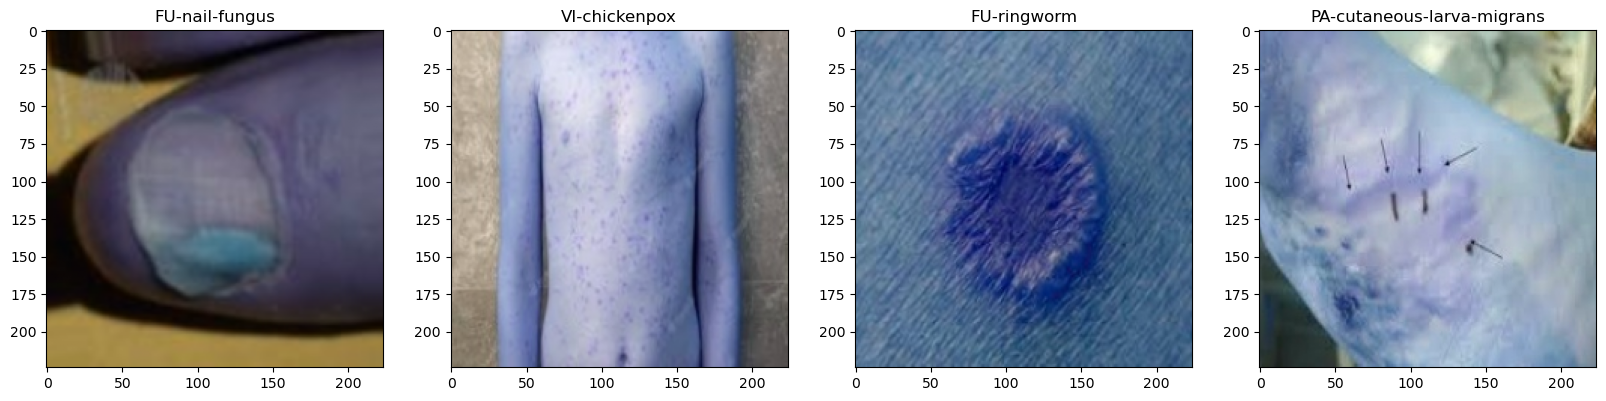

In [69]:
# Plotting Sample of the dataset
plot_images = train_x.reshape((len(train_x),224,224,3))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

# Looping over 4 images and plotting them
for index, image in enumerate(train_x[:4]):
    ax[index].imshow(plot_images[index])
    ax[index].title.set_text(train_y[index])
    
# Open-CV used BGR as standard, which is the reason colors are off

## • Define Model

In [ ]:
rfc = RandomForestClassifier(random_state=1)

## • Train Model

In [ ]:
rfc.fit(train_x, train_y)

## • Gathering Model Results

In [14]:
%%time
# __min __s (200 images) on Macbook Air m2
# 14min 18s (200 images) on desktop
result_image_count = 200

y_pred_train = rfc.predict(train_x[:result_image_count])
y_pred_test = rfc.predict(test_x[:result_image_count])

CPU times: total: 57min 5s
Wall time: 14min 18s


### • Accuracy Score

In [16]:
print(f"Training accuracy:  {accuracy_score(train_y[:result_image_count], y_pred_train)}")
print(f"Test accuracy:  {accuracy_score(test_y[:result_image_count], y_pred_test)}")

Training accuracy:  0.84
Test accuracy:  0.8


### • Classification Report

In [17]:
c_report = classification_report(test_y[:result_image_count],y_pred_test)
print(c_report)

                            precision    recall  f1-score   support

            BA- cellulitis       0.85      0.79      0.82        29
               BA-impetigo       0.85      0.79      0.81        14
           FU-athlete-foot       0.96      0.92      0.94        24
            FU-nail-fungus       0.81      0.83      0.82        30
               FU-ringworm       0.86      0.70      0.78        27
PA-cutaneous-larva-migrans       0.74      0.74      0.74        19
             VI-chickenpox       0.88      0.88      0.88        33
               VI-shingles       0.53      0.71      0.61        24

                  accuracy                           0.80       200
                 macro avg       0.81      0.79      0.80       200
              weighted avg       0.81      0.80      0.80       200



## • Load model

In [5]:
model_path = "../../Saved_Models/rfc_rbf.h5"
rfc = pickle.load(open(model_path, 'rb'))

CPU times: total: 2.53 s
Wall time: 10.4 s


## • Export model as pickle

In [72]:
%%time
# __min __s on Macbook Air m2
# __min __s on desktop
save_model ="../../Saved_Models/rfc_large_augmented.h5"
pickle.dump(rfc, open(save_model, 'wb'))

## • Predict with model

Actual Class: PA-cutaneous-larva-migrans
Predicted Class: PA-cutaneous-larva-migrans
   --- Correctly Classified ---   
CPU times: total: 11 s
Wall time: 2.84 s


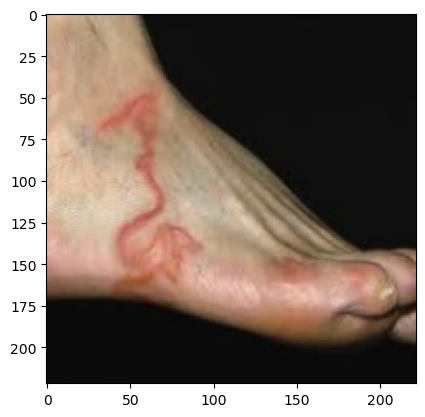

In [18]:
# Load new image to predict
image_path = './Data/original_data/PA-cutaneous-larva-migrans/68_PA-cutaneous-larva-migrans (33).jpg'
actual_class = image_path.split("/")[-2]
predict_image = cv2.imread(image_path)
predict_image = cv2.resize(predict_image, (224,224))
predict_image = np.array(predict_image.flatten()).reshape(1,-1)/255

RGB_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
plt.imshow(RGB_image)

# Get prediction
prediction = rfc.predict(predict_image)[0]
print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {prediction}")

if prediction == actual_class:
    print("   --- Correctly Classified ---   ")
else:
    print("   --- Incorrectly Classified ---   ")

# 5. Convolutional Neural Network (CNN)

## • Importing Tensorflow libraries for CNN model

In [122]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

## • Loading data with tensorflow

In [142]:
train = tf.keras.utils.image_dataset_from_directory("./Data/test/train/",image_size=(224,224))
val = tf.keras.utils.image_dataset_from_directory("./Data/test/val/", image_size=(224,224))

Found 8906 files belonging to 8 classes.
Found 2545 files belonging to 8 classes.


## • Transforming from regular 0-255 values to 0-1 values

In [143]:
train = train.map(lambda x,y: (x/255, y))
val = val.map(lambda x,y: (x/255, y))

## • Defining Model Structure

In [183]:
cnn = Sequential()

In [190]:
del(cnn)

In [53]:
# loss: 0.7463 - accuracy: 0.7179 - val_loss: 0.7083 - val_accuracy: 0.8028 (5 epochs) maybe try few more.
cnn.add(Conv2D(32, 3, activation = "relu", padding = 'same', input_shape = (224, 224, 3)))
cnn.add(MaxPooling2D())

cnn.add(Conv2D(32, 3, activation = "relu", padding = 'same'))
cnn.add(MaxPooling2D())
cnn.add(BatchNormalization())

cnn.add(Flatten())
cnn.add(Dense(64, activation = "relu"))
#cnn.add(Dense(512, activation = "relu"))
cnn.add(Dropout(0.2))
cnn.add(Dense(8, activation = 'softmax'))
# id = 1

In [126]:
# loss: 0.6205 - accuracy: 0.7823 - val_loss: 0.6776 - val_accuracy: 0.8263 (5 epochs) try more
cnn.add(Conv2D(16, 3, activation = "relu", padding = 'same', input_shape = (224, 224, 3)))
cnn.add(MaxPooling2D())

cnn.add(Conv2D(16, 3, activation = "relu", padding = 'same'))
cnn.add(MaxPooling2D())
cnn.add(BatchNormalization())

cnn.add(Flatten())
cnn.add(Dense(128, activation = "relu"))
#cnn.add(Dense(512, activation = "relu"))
cnn.add(Dropout(0.2))
cnn.add(Dense(8, activation = 'softmax'))
# id = 2

In [ ]:
# loss: 0.1639 - accuracy: 0.9488 - val_loss: 0.5231 - val_accuracy: 0.8888 (7 epochs)
cnn.add(Conv2D(16, 3, activation = "relu", padding = 'same', input_shape = (224, 224, 3)))
cnn.add(MaxPooling2D())

cnn.add(Conv2D(32, 3, activation = "relu", padding = 'same'))
cnn.add(MaxPooling2D())

cnn.add(Conv2D(16, 3, activation = "relu", padding = 'same'))
cnn.add(MaxPooling2D())
cnn.add(BatchNormalization())

cnn.add(Flatten())
cnn.add(Dense(128, activation = "relu"))
#cnn.add(Dense(512, activation = "relu"))
cnn.add(Dropout(0.2))
cnn.add(Dense(8, activation = 'softmax'))
# id = 3

In [184]:
# TEST THIS 5 epoch
cnn.add(Conv2D(64, 3, activation = "relu", padding = 'same', input_shape = (224, 224, 3)))
cnn.add(MaxPooling2D())

cnn.add(Conv2D(32, 3, activation = "relu", padding = 'same'))
cnn.add(MaxPooling2D())

cnn.add(BatchNormalization())

cnn.add(Flatten())
cnn.add(Dense(128, activation = "relu"))
cnn.add(Dropout(0.15))

cnn.add(Dense(8, activation = 'softmax'))
# id = 4

In [ ]:
cnn.summary()

## • Compiling and training model

In [186]:
cnn.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [187]:
# Logging results in logs folder
logdir='logs'

In [188]:
# Allow tensorflow to log data
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
%%time
# __min __s on Macbook Air m2
# 28min 47s on desktop
# Saving stats in hist and fitting model.
hist = cnn.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

## • Results

### • Plotting Training Statistics

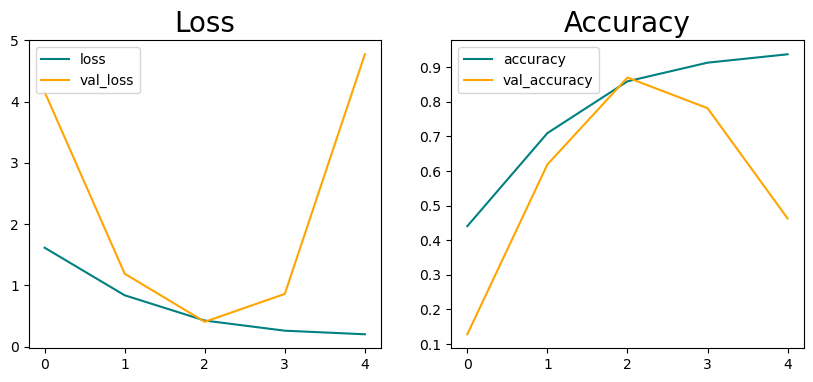

In [179]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val_loss')
ax[0].set_title('Loss', fontsize=20)
ax[0].legend(loc="upper left")

ax[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
ax[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend(loc="upper left")
plt.show()

## • Load model

In [ ]:
# Model saved in Saved_Models folder in the desktop
cnn = tf.keras.models.load_model('../../Saved_Models/CNN_079.h5')

## • Export model as pickle

In [140]:
# Save model to Saved_Models folder in the desktop
cnn.save(os.path.join("../../Saved_Models","CNN_id_3.h5"))

## • Model Prediction

#### • Loading unseen image for prediction

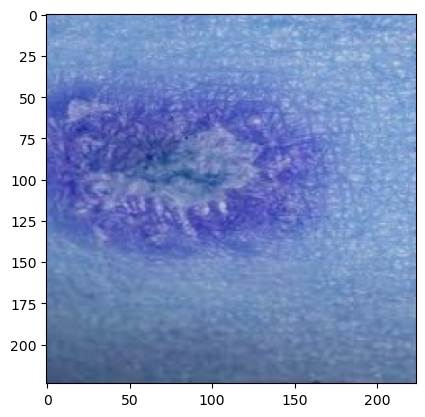

In [180]:
pred_image = cv2.imread('./Data/test/test/FU-ringworm/vf_b_8170_81_FU-ringworm (6).jpeg')
resize = tf.image.resize(pred_image, (224,224))
plt.imshow(resize.numpy().astype(int))

#### • Mapping Classes to indexes

In [103]:
class_map = {
    0: 'BA- cellulitis',
    1: 'BA-impetigo',
    2: 'FU-athlete-foot',
    3: 'FU-nail-fungus',
    4: 'FU-ringworm',
    5: 'PA-cutaneous-larva-migrans',
    6: 'VI-chickenpox',
    7: 'VI-shingles'}

#### • Resizing and prediction

In [181]:
# Resizing image from 0-255 to 0-1
pred_image = resize/255

# Expading dimension for it to fit the model
yhat = cnn.predict(np.expand_dims(pred_image, 0))

# Printing prediction values
print(yhat)

# Finding prediction with highest value
print(f"{class_map[np.argmax(yhat)]}")

1/1 [==============================] - 0s 99ms/step
[[9.9999738e-01 6.5567641e-13 7.2972123e-12 2.6356697e-06 1.5744671e-13
  4.1285149e-09 2.3116875e-11 1.8763931e-12]]
BA- cellulitis


# 6. Support Vector Machine (SVM)

## • Importing Libraries

In [145]:
from sklearn.svm import SVC

## • Loading Data

In [12]:
train_path = "./Data/data/train/" # Augmented Data
val_path = "./Data/data/val/" # Augmented Data
test_path = "./Data/data/test/" # Augmented Data

# Create Data_Loader object
data = Data_Loader()

In [13]:
# Generate data split from data class object.
train_x ,train_y = data.generate_image_array(train_path)
test_x ,test_y = data.generate_image_array(test_path)

CPU times: total: 26.4 s
Wall time: 29.8 s


## • Visualizing Loaded Data

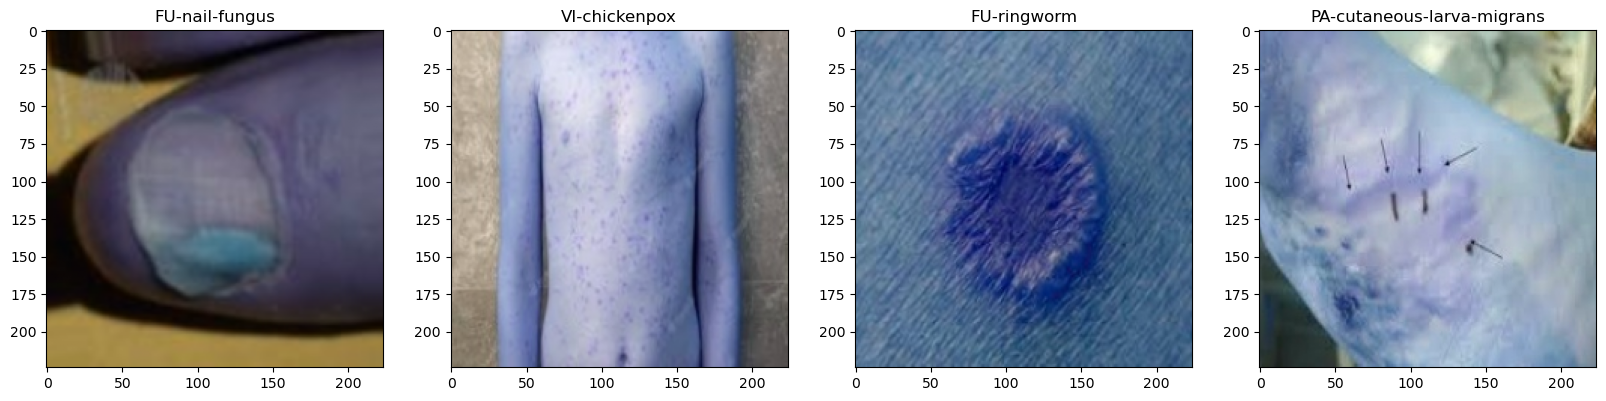

In [69]:
# Plotting Sample of the dataset
plot_images = train_x.reshape((len(train_x),224,224,3))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

# Looping over 4 images and plotting them
for index, image in enumerate(train_x[:4]):
    ax[index].imshow(plot_images[index])
    ax[index].title.set_text(train_y[index])
    
# Open-CV used BGR as standard, which is the reason colors are off

## • Training Support Vector Classifier (SVC)

In [70]:
%%time
# __min __s on Macbook Air m2
# 25min 36s on desktop
svc = SVC(kernel="rbf")
svc.fit(train_x,train_y)

CPU times: total: 1h 41min 11s
Wall time: 25min 36s


SVC()

## • Gathering Model Results

In [14]:
%%time
# __min __s (200 images) on Macbook Air m2
# 14min 18s (200 images) on desktop
result_image_count = 200

y_pred_train = svc.predict(train_x[:result_image_count])
y_pred_test = svc.predict(test_x[:result_image_count])

CPU times: total: 57min 5s
Wall time: 14min 18s


### • Accuracy Score

In [16]:
print(f"Training accuracy:  {accuracy_score(train_y[:result_image_count], y_pred_train)}")
print(f"Test accuracy:  {accuracy_score(test_y[:result_image_count], y_pred_test)}")

Training accuracy:  0.84
Test accuracy:  0.8


### • Classification Report

In [17]:
c_report = classification_report(test_y[:result_image_count],y_pred_test)
print(c_report)

                            precision    recall  f1-score   support

            BA- cellulitis       0.85      0.79      0.82        29
               BA-impetigo       0.85      0.79      0.81        14
           FU-athlete-foot       0.96      0.92      0.94        24
            FU-nail-fungus       0.81      0.83      0.82        30
               FU-ringworm       0.86      0.70      0.78        27
PA-cutaneous-larva-migrans       0.74      0.74      0.74        19
             VI-chickenpox       0.88      0.88      0.88        33
               VI-shingles       0.53      0.71      0.61        24

                  accuracy                           0.80       200
                 macro avg       0.81      0.79      0.80       200
              weighted avg       0.81      0.80      0.80       200



## • Load model

In [5]:
model_path = "../../Saved_Models/svc_rbf.h5"
svc = pickle.load(open(model_path, 'rb'))

CPU times: total: 2.53 s
Wall time: 10.4 s


## • Export model as pickle

In [72]:
%%time
# __min __s on Macbook Air m2
# __min __s on desktop
save_model ="../../Saved_Models/SVC_large_augmented.h5"
pickle.dump(svc, open(save_model, 'wb'))

## • Predict with model

Actual Class: PA-cutaneous-larva-migrans
Predicted Class: PA-cutaneous-larva-migrans
   --- Correctly Classified ---   
CPU times: total: 11 s
Wall time: 2.84 s


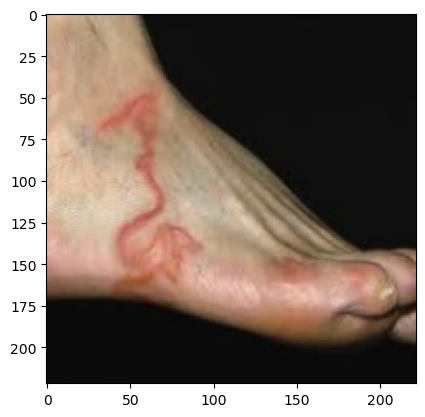

In [18]:
# Load new image to predict
image_path = './Data/original_data/PA-cutaneous-larva-migrans/68_PA-cutaneous-larva-migrans (33).jpg'
actual_class = image_path.split("/")[-2]
predict_image = cv2.imread(image_path)
predict_image = cv2.resize(predict_image, (224,224))
predict_image = np.array(predict_image.flatten()).reshape(1,-1)/255

RGB_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
plt.imshow(RGB_image)

# Get prediction
prediction = svc.predict(predict_image)[0]
print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {prediction}")

if prediction == actual_class:
    print("   --- Correctly Classified ---   ")
else:
    print("   --- Incorrectly Classified ---   ")

# 7. Other Interesting insights

## • Plotting sum of coloumns on graph

We thought we could see if there are any visible patterns in the classes from the sum of coloumns or rows, and if this maybe could be used to train a model.

In [534]:
def generate_sobel(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224,224))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F,0,1)
    return sobel_y

In [620]:
def plotting_summed_coloumns(image_paths_list, class_name, sobel=False):
    by_coloumn = []
    by_row = []
    
    for image in image_paths_list:
        # Load image, resize to 224, 224 and convert to grayscale
        if sobel == True:
            current_image = generate_sobel(image)
        else:
            current_image = cv2.imread(image)
            current_image = cv2.resize(current_image, (224,224))
            current_image = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
        
        # Sum every coloumn and divide by rows to get average per coloumn
        by_coloumn.append(np.sum(current_image, axis=0)/244)
        by_row.append(np.sum(current_image, axis=1)/244)
    by_coloumn = np.array(by_coloumn)
    by_row = np.array(by_row)
    
    # Plot result
    x_axis = np.arange(1,225)

    fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16,6))
    if sobel == True:
        fig.suptitle(f"{class_name} - Sobel_y")
    else:
        fig.suptitle(f"{class_name}")
        
    plt.subplots_adjust(hspace=0.4)
    for idx in range(0,4):
        ax[0][idx].plot(x_axis, by_coloumn[idx])
        ax[0][idx].set_title("By Coloumn")
        
    for idx in range(0,4):
        ax[1][idx].plot(x_axis, by_row[idx])
        ax[1][idx].set_title("By Row")
    plt.show()
    

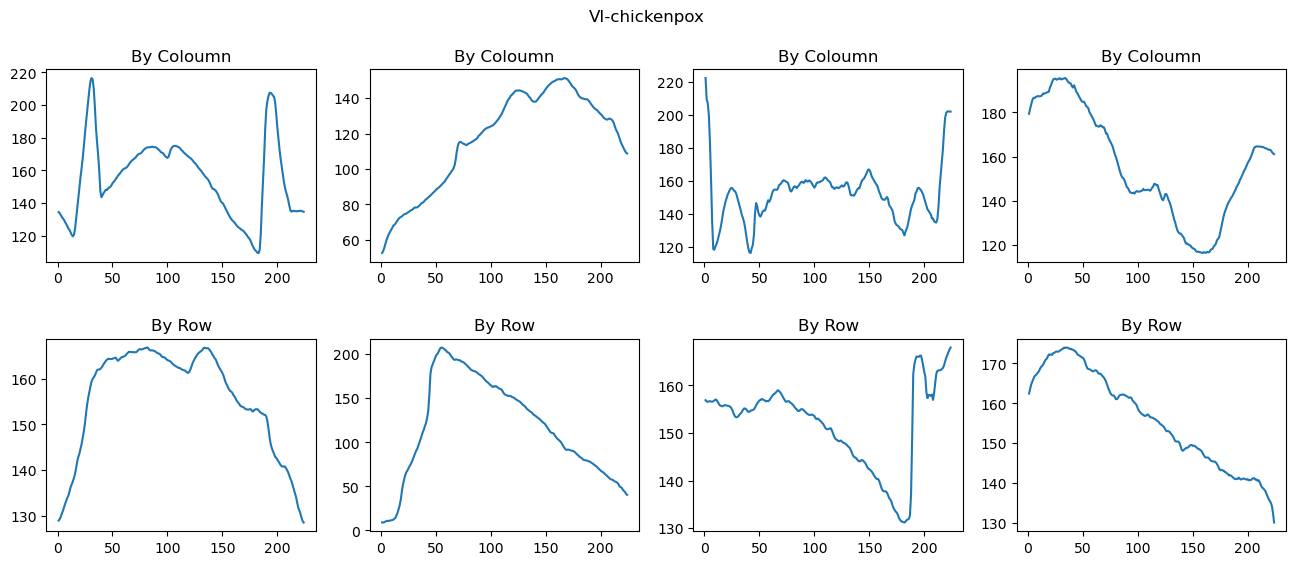

In [633]:
img_1 = "./Data/original_data/VI-chickenpox/110_VI-chickenpox (12).jpg"
img_2 = "./Data/original_data/VI-chickenpox/157_VI-chickenpox (14).jpg"
img_3 = "./Data/original_data/VI-chickenpox/24_VI-chickenpox (16).jpg"
img_4 = "./Data/original_data/VI-chickenpox/57_VI-chickenpox (7).jpg"
class_name = img_1.split("/")[3]
plotting_summed_coloumns([img_1, img_2, img_3, img_4], class_name, sobel=False)

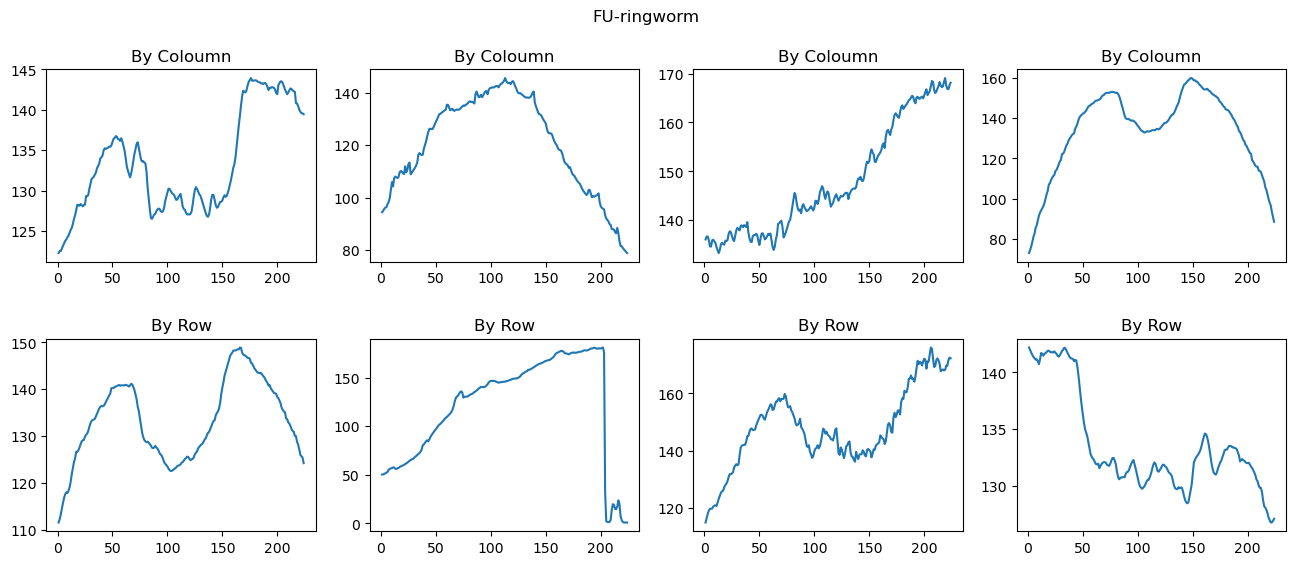

In [634]:
img_1 = "./Data/original_data/FU-ringworm/112_FU-ringworm (1).jpeg"
img_2 = "./Data/original_data/FU-ringworm/55_FU-ringworm (66).jpg"
img_3 = "./Data/original_data/FU-ringworm/81_FU-ringworm (6).jpeg"
img_4 = "./Data/original_data/FU-ringworm/92_FU-ringworm (45).jpg"
class_name = img_1.split("/")[3]

plotting_summed_coloumns([img_1, img_2, img_3, img_4], class_name, sobel=False)

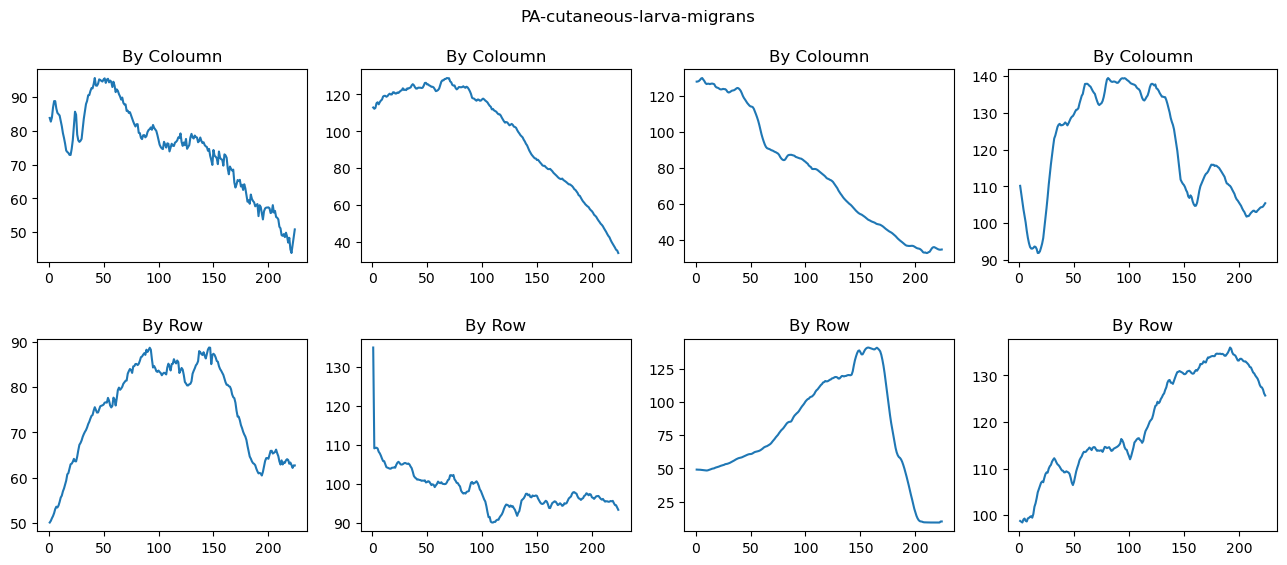

In [635]:
img_1 = "./Data/original_data/PA-cutaneous-larva-migrans/124_PA-cutaneous-larva-migrans (51).jpg"
img_2 = "./Data/original_data/PA-cutaneous-larva-migrans/4_PA-cutaneous-larva-migrans (18).jpg"
img_3 = "./Data/original_data/PA-cutaneous-larva-migrans/68_PA-cutaneous-larva-migrans (33).jpg"
img_4 = "./Data/original_data/PA-cutaneous-larva-migrans/89_PA-cutaneous-larva-migrans (66).jpg"
class_name = img_1.split("/")[3]
plotting_summed_coloumns([img_1, img_2, img_3, img_4], class_name, sobel=False)